In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np

In [2]:
# Load your data
df = pd.read_csv("cases_engineered.csv")

/var/folders/cy/6vqfws0d4fb41pz_h_l50xjc0000gn/T/ipykernel_20889/1081693479.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("cases_engineered.csv")


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36480733 entries, 0 to 36480732
Data columns (total 26 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   act                    float64
 1   section                float64
 2   bailable_ipc           object 
 3   number_sections_ipc    float64
 4   criminal               int64  
 5   female_defendant       int64  
 6   female_petitioner      int64  
 7   type_name              float64
 8   date_of_filing         object 
 9   date_first_list        object 
 10  case_duration_days     float64
 11  event                  int64  
 12  court_details          object 
 13  state_district         object 
 14  judge_category         object 
 15  filing_year            int64  
 16  filing_month           int64  
 17  filing_quarter         int64  
 18  filing_dayofweek       int64  
 19  filing_dayofyear       int64  
 20  filing_weekofyear      int64  
 21  first_list_delay       int64  
 22  first_list_month

In [4]:

# Convert dates
date_cols = ['date_of_filing', 'date_first_list']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

# Create basic features first
df['days_to_first_list'] = (df['date_first_list'] - df['date_of_filing']).dt.days
df['filing_month'] = df['date_of_filing'].dt.month

# Take 1% random sample (≈364,807 cases - still large!)
sample_size = 0.3
df_sample = df.sample(frac=sample_size, random_state=42)

print(f"Original size: {len(df):,} cases")
print(f"Sample size: {len(df_sample):,} cases ({sample_size*100:.1f}%)")
print(f"Sample represents {len(df_sample)/len(df)*100:.2f}% of data")

Original size: 36,480,733 cases
Sample size: 10,944,220 cases (30.0%)
Sample represents 30.00% of data


In [5]:
print("\n=== CASE DURATION PREDICTION MODEL WITH FEATURE ENGINEERING ===")

# Since you already have engineered features, we'll work with df_sample directly
df_engineered = df_sample.copy()

print(f"Number of features after engineering: {len(df_engineered.columns)}")

# List of engineered features that should be in your CSV
engineered_cols = ['judge_category', 'filing_year', 'filing_month', 'filing_quarter', 
                   'filing_dayofweek', 'filing_dayofyear', 'filing_weekofyear',
                   'first_list_delay', 'first_list_month', 'first_list_quarter',
                   'filed_on_weekend', 'first_list_on_weekend']

# Prepare features for modeling
print("\n=== PREPARING DATA FOR MODELING ===")

# Define feature sets
raw_features = [
    'act', 'section', 'bailable_ipc', 'number_sections_ipc', 
    'criminal', 'female_defendant', 'female_petitioner', 
    'type_name', 'court_details', 'state_district'
]

# Check which features exist in our dataframe
available_raw_features = [col for col in raw_features if col in df_engineered.columns]
available_engineered_features = [col for col in engineered_cols if col in df_engineered.columns]

# Combine all features
all_features = available_raw_features + available_engineered_features

print(f"Raw features available: {len(available_raw_features)}/{len(raw_features)}")
print(f"Engineered features available: {len(available_engineered_features)}/{len(engineered_cols)}")
print(f"Total features for modeling: {len(all_features)}")

# Prepare X and y
X = df_engineered[all_features].copy()
y = df_engineered['case_duration_days']

# Check for target variable
if 'case_duration_days' not in df_engineered.columns:
    print("ERROR: 'case_duration_days' not found in dataframe!")
    print("Available columns:", df_engineered.columns.tolist())
    exit()


# Encode categorical variables
print("\n=== ENCODING CATEGORICAL VARIABLES ===")
categorical_cols = X.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    if col in X.columns:
        le = LabelEncoder()
        # Handle any remaining NaN by converting to string
        X[col] = X[col].astype(str)
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
        print(f"  Encoded {col} ({len(le.classes_)} unique values)")

# Remove any remaining NaN in target
mask = y.notna()
X = X[mask]
y = y[mask]


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining samples: {len(X_train):,}")
print(f"Testing samples:  {len(X_test):,}")

# Train Random Forest model
print("\n=== TRAINING RANDOM FOREST MODEL ===")
print("This may take a few minutes...")

model = RandomForestRegressor(
    n_estimators=200,
    max_depth=25,
    n_jobs=-1,
    random_state=42
)

model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n=== MODEL PERFORMANCE (WITH FEATURE ENGINEERING) ===")
print(f"Mean Absolute Error (MAE): {mae:.2f} days")
print(f"R² Score: {r2:.4f}")
print(f"Mean actual duration: {y.mean():.2f} days")
print(f"Std actual duration: {y.std():.2f} days")

# Feature importance analysis
feature_importances = pd.DataFrame({
    'feature': all_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n=== TOP 15 MOST IMPORTANT FEATURES ===")
for i, (_, row) in enumerate(feature_importances.head(15).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:30s} : {row['importance']:.4f}")

# Analyze prediction errors
errors = y_test - y_pred
abs_errors = np.abs(errors)

print(f"\n=== ERROR ANALYSIS ===")
print(f"\nPercentage of predictions within:")
print(f"  ±30 days: {(abs_errors <= 30).mean()*100:.1f}%")
print(f"  ±90 days: {(abs_errors <= 90).mean()*100:.1f}%")
print(f"  ±180 days: {(abs_errors <= 180).mean()*100:.1f}%")
print(f"  ±365 days: {(abs_errors <= 365).mean()*100:.1f}%")

# Check distribution of predictions vs actual
print(f"\n=== PREDICTION DISTRIBUTION ===")
print(f"Actual duration range: {y.min():.1f} to {y.max():.1f} days")
print(f"Predicted duration range: {y_pred.min():.1f} to {y_pred.max():.1f} days")
print(f"Mean predicted: {y_pred.mean():.1f} days")
print(f"Mean actual: {y_test.mean():.1f} days")

# Calculate additional metrics
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} days")

# Save predictions for analysis
predictions_df = pd.DataFrame({
    'actual_duration': y_test.values,
    'predicted_duration': y_pred,
    'error': errors,
    'abs_error': abs_errors
})

print("\n=== MODEL TRAINING COMPLETE ===")


=== CASE DURATION PREDICTION MODEL WITH FEATURE ENGINEERING ===
Number of features after engineering: 27

=== PREPARING DATA FOR MODELING ===
Raw features available: 10/10
Engineered features available: 12/12
Total features for modeling: 22

=== ENCODING CATEGORICAL VARIABLES ===
  Encoded bailable_ipc (6 unique values)
  Encoded court_details (6852 unique values)
  Encoded state_district (632 unique values)
  Encoded judge_category (16 unique values)

Training samples: 8,755,376
Testing samples:  2,188,844

=== TRAINING RANDOM FOREST MODEL ===
This may take a few minutes...

=== MODEL PERFORMANCE (WITH FEATURE ENGINEERING) ===
Mean Absolute Error (MAE): 254.33 days
R² Score: 0.5689
Mean actual duration: 561.94 days
Std actual duration: 568.29 days

=== TOP 15 MOST IMPORTANT FEATURES ===
 1. first_list_delay               : 0.2275
 2. type_name                      : 0.1901
 3. court_details                  : 0.1160
 4. section                        : 0.1065
 5. act                 

5-Bin Classification Performance:
Accuracy: 0.6775594788847447
Precision (weighted): 0.7741410486869199
Recall (weighted): 0.6775594788847447
F1 Score (weighted): 0.6844173379112266

Classification Report:

              precision    recall  f1-score   support

     <1 year       0.94      0.70      0.80   1130119
   1–3 years       0.46      0.88      0.61    595506
    >3 years       0.77      0.37      0.50    463219

    accuracy                           0.68   2188844
   macro avg       0.72      0.65      0.64   2188844
weighted avg       0.77      0.68      0.68   2188844



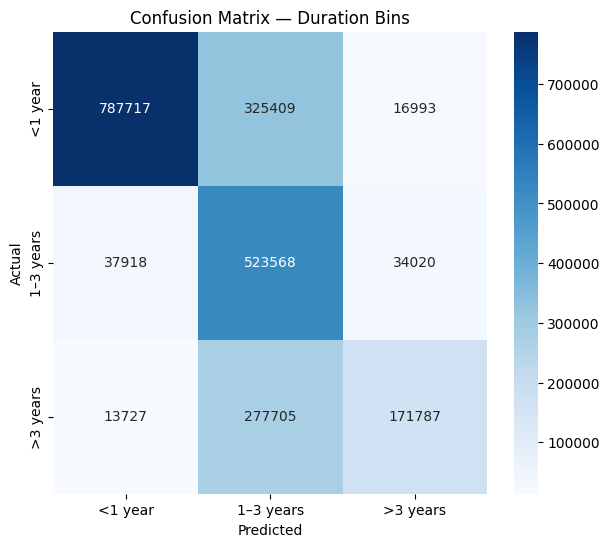

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1. Define the 5-bin classifier function
# ------------------------------------------------------
def duration_to_class_5bins(x):
    if x < 365:
        return 0   # < 1 year
    elif x < 1095:
        return 1   # 1 to <3 years
    else :
        return 2   # >3 years
    

class_names = [
    "<1 year",
    "1–3 years",
    ">3 years"
]

# ------------------------------------------------------
# 2. Prepare true and predicted durations
#    (if you trained on log1p, do inverse transform)
# ------------------------------------------------------

y_test_true = np.array(y_test)        # or np.expm1(y_test_log)
y_pred_true = np.array(y_pred)        # or np.expm1(y_pred_log)

# ------------------------------------------------------
# 3. Convert durations → classes
# ------------------------------------------------------

y_test_cls = np.vectorize(duration_to_class_5bins)(y_test_true)
y_pred_cls = np.vectorize(duration_to_class_5bins)(y_pred_true)

# ------------------------------------------------------
# 4. Compute classification metrics
# ------------------------------------------------------

accuracy = accuracy_score(y_test_cls, y_pred_cls)
precision = precision_score(y_test_cls, y_pred_cls, average="weighted", zero_division=0)
recall = recall_score(y_test_cls, y_pred_cls, average="weighted", zero_division=0)
f1 = f1_score(y_test_cls, y_pred_cls, average="weighted", zero_division=0)

print("5-Bin Classification Performance:")
print("Accuracy:", accuracy)
print("Precision (weighted):", precision)
print("Recall (weighted):", recall)
print("F1 Score (weighted):", f1)

# ------------------------------------------------------
# 5. Detailed Classification Report
# ------------------------------------------------------

print("\nClassification Report:\n")
print(classification_report(y_test_cls, y_pred_cls, target_names=class_names, zero_division=0))

# ------------------------------------------------------
# 6. Confusion Matrix
# ------------------------------------------------------

cm = confusion_matrix(y_test_cls, y_pred_cls, labels=[0,1,2])
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix — Duration Bins")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


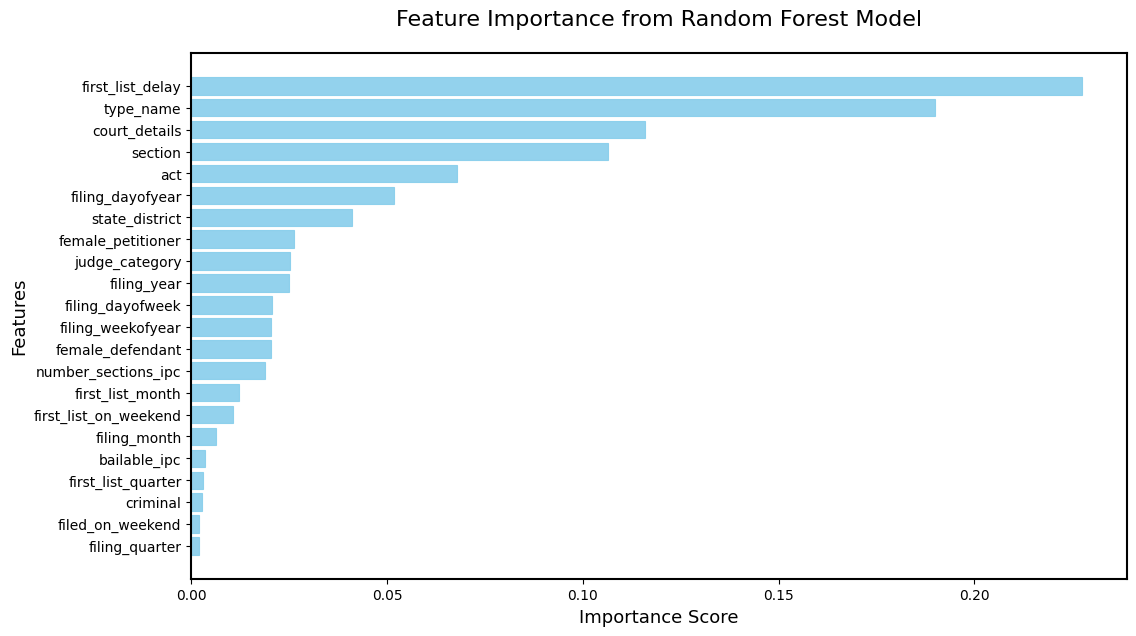

: 

In [ ]:
# Sort feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
sorted_features = [all_features[i] for i in indices]
sorted_importances = importances[indices]

# Figure setup
plt.figure(figsize=(12, 7))

# Horizontal bar plot
plt.barh(
    sorted_features[::-1],
    sorted_importances[::-1],
    color="skyblue",
    edgecolor="skyblue",
    linewidth=0.8,
    alpha=0.9
)

# Axis labels and title
plt.xlabel("Importance Score", fontsize=13)
plt.ylabel("Features", fontsize=13)
plt.title(
    "Feature Importance from Random Forest Model",
    fontsize=16,
    fontweight="regular",
    pad=20
)

# Clean black frame
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)


# Layout
plt.tight_layout(pad=3)
plt.show()
